<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 0 to 79
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tag            661 non-null    object
 1   patterns       661 non-null    object
 2   responses      661 non-null    object
 3   patterns_str   661 non-null    object
 4   responses_str  661 non-null    object
dtypes: object(5)
memory usage: 31.0+ KB
None
        tag patterns                                          responses  \
0  greeting       hi    hello there. tell me how are you feeling today?   
0  greeting       hi              hi there. what brings you here today?   
0  greeting       hi               hi there. how are you feeling today?   
0  greeting       hi       great to see you. how do you feel currently?   
0  greeting       hi  hello there. glad to see you're back. what's g...   

                                        patterns_str  \
0  Hi Hey Is anyone there? Hi there Hello H

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  patterns patterns_tokens                                          responses  \
0       hi            [hi]    hello there. tell me how are you feeling today?   
0       hi            [hi]              hi there. what brings you here today?   
0       hi            [hi]               hi there. how are you feeling today?   
0       hi            [hi]       great to see you. how do you feel currently?   
0       hi            [hi]  hello there. glad to see you're back. what's g...   

                                    responses_tokens  
0  [hello, there, tell, me, how, are, you, feelin...  
0        [hi, there, what, brings, you, here, today]  
0         [hi, there, how, are, you, feeling, today]  
0  [great, to, see, you, how, do, you, feel, curr...  
0  [hello, there, glad, to, see, youre, back, wha...  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


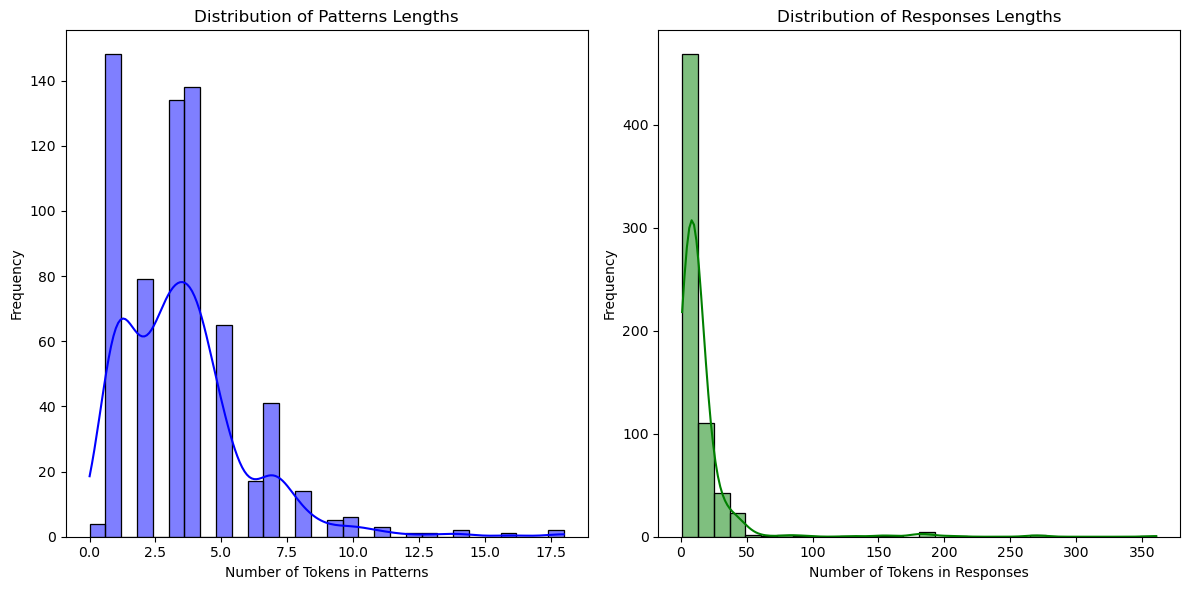

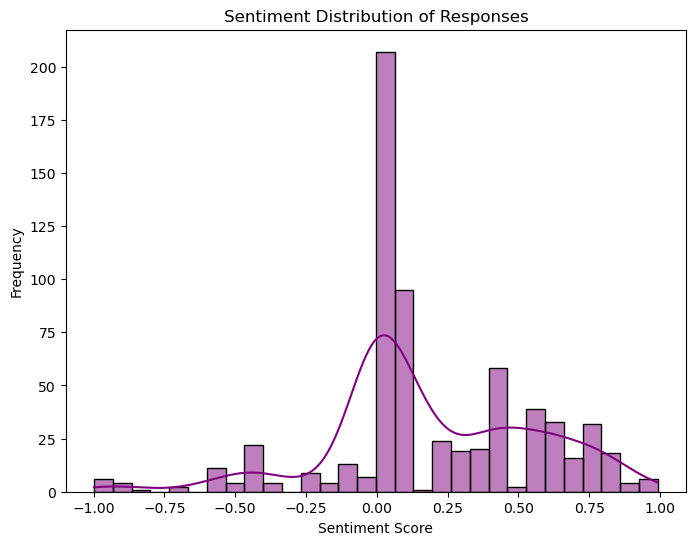

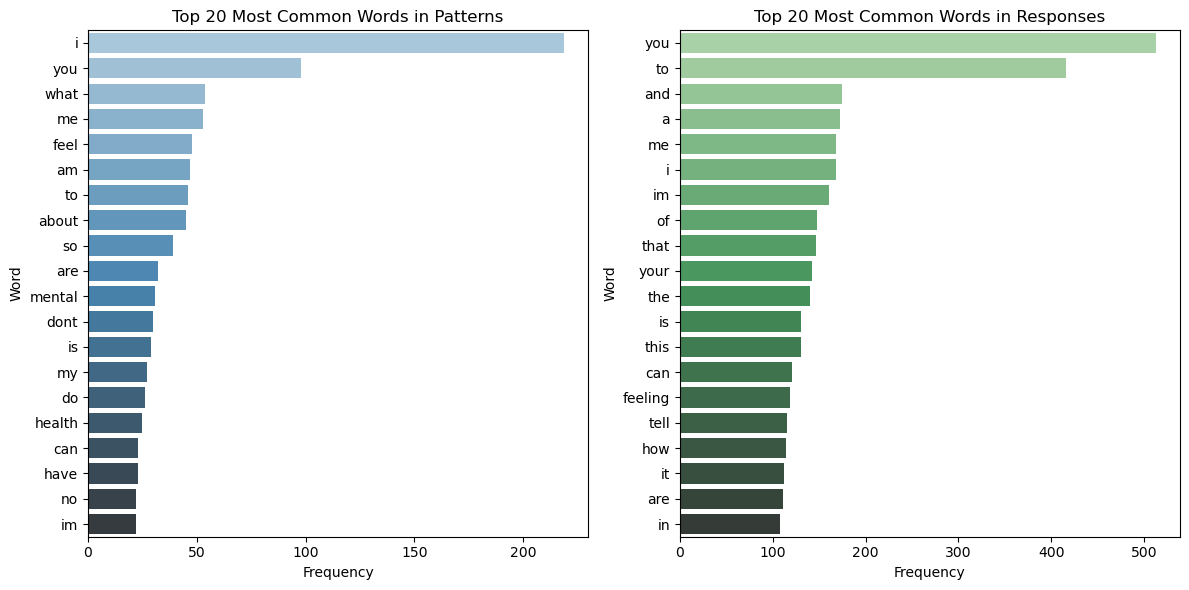

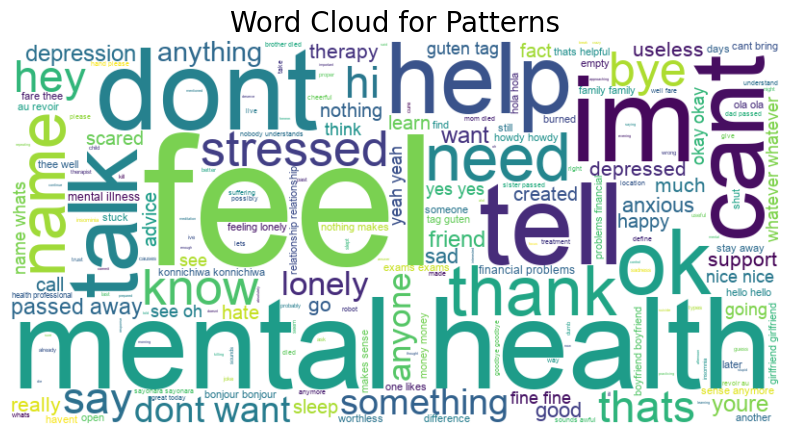

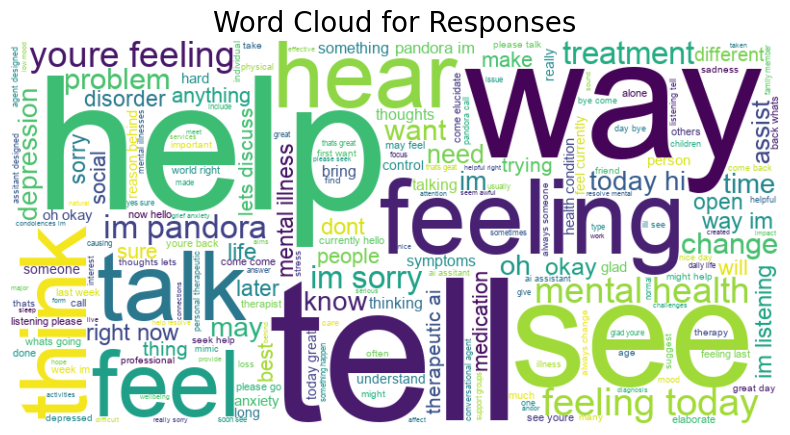

Training Set Sentiment Distribution:
 positive    0.554924
neutral     0.323864
negative    0.121212
Name: Sentiment_Label, dtype: float64

Test Set Sentiment Distribution:
 positive    0.556391
neutral     0.323308
negative    0.120301
Name: Sentiment_Label, dtype: float64


In [1]:
import os
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import json

# Load the dataset
file_path = r"C:\Users\dell\Downloads\archive\intents.json"  # Update with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
intents = data['intents']
df = pd.DataFrame(intents)

# Handle missing values by dropping rows where 'patterns' or 'responses' is null
cleaned_data = df.dropna(subset=['patterns', 'responses'])

# Convert lists to strings to remove duplicates
cleaned_data['patterns_str'] = cleaned_data['patterns'].apply(lambda x: ' '.join(x))
cleaned_data['responses_str'] = cleaned_data['responses'].apply(lambda x: ' '.join(x))

# Remove duplicates
cleaned_data = cleaned_data.drop_duplicates(subset=['patterns_str', 'responses_str'])

# Standardize text: Convert all text in 'patterns' and 'responses' columns to lowercase and strip leading/trailing spaces
cleaned_data['patterns'] = cleaned_data['patterns'].apply(lambda x: [pattern.lower().strip() for pattern in x])
cleaned_data['responses'] = cleaned_data['responses'].apply(lambda x: [response.lower().strip() for response in x])

# Flatten 'patterns' and 'responses' for easier processing
cleaned_data = cleaned_data.explode('patterns')
cleaned_data = cleaned_data.explode('responses')

# Save the cleaned dataset to a new file
cleaned_file_path = 'Cleaned_Dataset.csv'  # Update with your desired output file path
cleaned_data.to_csv(cleaned_file_path, index=False)

# Optional: Display some information about the cleaned dataset
print(cleaned_data.info())
print(cleaned_data.head())

# Download NLTK tokenizer models
nltk.download('punkt')

# Function to normalize and tokenize text
def normalize_and_tokenize(text):
    # Remove non-alphabetic characters (punctuation, numbers)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    return tokens

# Apply normalization and tokenization to 'patterns' and 'responses' columns
cleaned_data['patterns_tokens'] = cleaned_data['patterns'].apply(normalize_and_tokenize)
cleaned_data['responses_tokens'] = cleaned_data['responses'].apply(normalize_and_tokenize)

# Show first few rows to verify the process
print(cleaned_data[['patterns', 'patterns_tokens', 'responses', 'responses_tokens']].head())

# Download VADER for sentiment analysis
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# 1. Text Length Distribution: patterns and responses
cleaned_data['patterns_len'] = cleaned_data['patterns_tokens'].apply(len)
cleaned_data['responses_len'] = cleaned_data['responses_tokens'].apply(len)

# Plot histograms of text lengths for patterns and responses
plt.figure(figsize=(12, 6))

# Patterns length distribution
plt.subplot(1, 2, 1)
sns.histplot(cleaned_data['patterns_len'], bins=30, kde=True, color='blue')
plt.title('Distribution of Patterns Lengths')
plt.xlabel('Number of Tokens in Patterns')
plt.ylabel('Frequency')

# Responses length distribution
plt.subplot(1, 2, 2)
sns.histplot(cleaned_data['responses_len'], bins=30, kde=True, color='green')
plt.title('Distribution of Responses Lengths')
plt.xlabel('Number of Tokens in Responses')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Sentiment Analysis on Responses
cleaned_data['Sentiment'] = cleaned_data['responses'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data['Sentiment'], bins=30, kde=True, color='purple')
plt.title('Sentiment Distribution of Responses')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 3. Most Common Words: Patterns and Responses
# Flatten token lists and calculate frequency distribution
patterns_words = [word for tokens in cleaned_data['patterns_tokens'] for word in tokens]
responses_words = [word for tokens in cleaned_data['responses_tokens'] for word in tokens]

patterns_freq_dist = FreqDist(patterns_words)
responses_freq_dist = FreqDist(responses_words)

# Plot top 20 most common words in patterns and responses
plt.figure(figsize=(12, 6))

# Patterns word frequency
plt.subplot(1, 2, 1)
patterns_common_words = pd.DataFrame(patterns_freq_dist.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=patterns_common_words, palette='Blues_d')
plt.title('Top 20 Most Common Words in Patterns')

# Responses word frequency
plt.subplot(1, 2, 2)
responses_common_words = pd.DataFrame(responses_freq_dist.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=responses_common_words, palette='Greens_d')
plt.title('Top 20 Most Common Words in Responses')

plt.tight_layout()
plt.show()

# Generate word cloud
def generate_word_cloud(text, title, color='white'):
    try:
        # Use a specific TrueType font if needed, otherwise default
        font_path = r"C:\Users\dell\Downloads\Arial (1).ttf"  # Example path for Arial font on Windows
        wordcloud = WordCloud(width=800, height=400, background_color=color, font_path=font_path).generate(' '.join(text))
    except ValueError as e:
        print(f"Error generating word cloud: {e}")
        wordcloud = WordCloud(width=800, height=400, background_color=color).generate(' '.join(text))
        
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Word Cloud for Patterns
generate_word_cloud(patterns_words, 'Word Cloud for Patterns', 'white')

# Word Cloud for Responses
generate_word_cloud(responses_words, 'Word Cloud for Responses', 'white')

# Sentiment Analysis
cleaned_data['Sentiment_Score'] = cleaned_data['responses'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Label sentiment as 'positive', 'neutral', or 'negative'
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

cleaned_data['Sentiment_Label'] = cleaned_data['Sentiment_Score'].apply(label_sentiment)

# Split the data into training and testing sets with balanced sentiment distribution
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, stratify=cleaned_data['Sentiment_Label'], random_state=42)

# Check the distribution in training and test sets
train_sentiment_distribution = train_data['Sentiment_Label'].value_counts(normalize=True)
test_sentiment_distribution = test_data['Sentiment_Label'].value_counts(normalize=True)

print("Training Set Sentiment Distribution:\n", train_sentiment_distribution)
print("\nTest Set Sentiment Distribution:\n", test_sentiment_distribution)

# Save train and test sets to CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Use the 'patterns_tokens' or 'responses_tokens' for sentiment classification
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_data['patterns_tokens'].apply(lambda x: ' '.join(x)))

# Using VADER sentiment labels as pseudo-ground truth for this demonstration
y = cleaned_data['Sentiment_Label']

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict sentiment on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model-Based Evaluation Accuracy: {accuracy * 100:.2f}%")

Model-Based Evaluation Accuracy: 66.17%
